<a href="https://colab.research.google.com/github/KillerStrike17/EVA---Session-1-Basics-Of-DNN/blob/master/Notebook_Shubham/EVA_research_grp2_test_distortion_in_mid_lower_layers_ResNet_v2(1_25_Epochs)_Single_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Choose tf2 backend on colab

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa

TensorFlow 2.x selected.


### Install tf_utils

In [0]:
!pip install --upgrade git+https://github.com/ravindrabharathi/tf_utils 

  Cloning https://github.com/ravindrabharathi/tf_utils to /tmp/pip-req-build-wfcke796
  Running command git clone -q https://github.com/ravindrabharathi/tf_utils /tmp/pip-req-build-wfcke796
  Created wheel for tf-utils: filename=tf_utils-0.1-cp36-none-any.whl size=8427 sha256=659debaed37916194883cc1cf40bf9eb98cc813335ff89b330f7228a31e6477e
  Stored in directory: /tmp/pip-ephem-wheel-cache-c563cgai/wheels/95/af/bb/690b94c65a5aad47a5c39e75f158a2b043448e908c5c121791
Successfully built tf-utils


### import the data module

In [0]:
import tf_utils.data as ds

Finished 'get_cpu_num' in 0.0000 secs


### set batch size

In [0]:
batch_size=512
ds.batch_size=batch_size
EPOCHS=24

### downlaod data and create tf records

In [0]:
ds.get_cifar10_and_create_tfrecords()


Finished 'download_file' in 6.5977 secs
Finished 'download_cifar10_files' in 6.5979 secs
Done
Finished 'extract_cifar10_files' in 2.0207 secs
Finished '_get_file_names' in 0.0000 secs
Generating ./train.tfrecords
Finished 'read_pickle_from_file' in 0.1640 secs
Finished 'read_pickle_from_file' in 0.1685 secs
Finished 'read_pickle_from_file' in 0.1501 secs
Finished 'read_pickle_from_file' in 0.1534 secs
Finished 'read_pickle_from_file' in 0.1802 secs
Finished 'convert_to_tfrecord' in 3.3129 secs
Done!
Generating ./eval.tfrecords
Finished 'read_pickle_from_file' in 0.1500 secs
Finished 'convert_to_tfrecord' in 0.7154 secs
Done!
Finished 'create_tf_records' in 4.0304 secs
Finished 'get_cifar10_and_create_tfrecords' in 12.6495 secs


### create train and test dataset

In [0]:
train_ds1=ds.get_train_ds(batch_size=batch_size,shuffle=True,distort=True)
train_ds2=ds.get_train_ds(batch_size=batch_size,shuffle=True,distort=False)

test_ds=ds.get_eval_ds(batch_size=batch_size)

distorting image
Finished 'get_tf_dataset' in 2.8128 secs
Finished 'get_tf_dataset_in_batches' in 2.8132 secs
Finished 'get_train_ds' in 2.8134 secs
Finished 'get_tf_dataset' in 0.1904 secs
Finished 'get_tf_dataset_in_batches' in 0.1908 secs
Finished 'get_train_ds' in 0.1911 secs
Finished 'get_tf_dataset' in 0.0337 secs
Finished 'get_tf_dataset_in_batches' in 0.0341 secs
Finished 'get_eval_ds' in 0.0342 secs


### import visualization module

In [0]:
import tf_utils.visualize as vz

### plot images from train dataset1 , train dataset by default uses image augmenttation of cutout,flip-left-right,random-pad-crop 

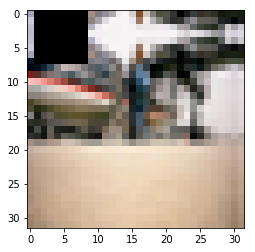

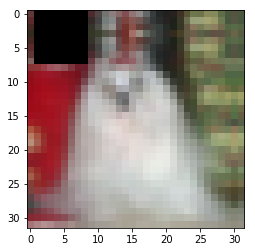

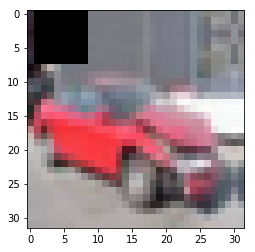

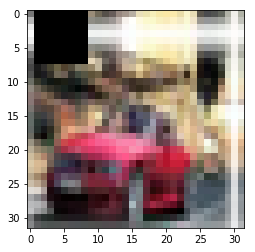

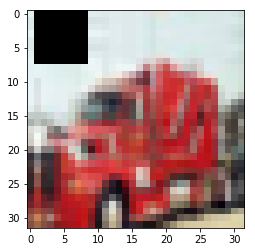

In [0]:
vz.plot_cifar10_files(train_ds1)

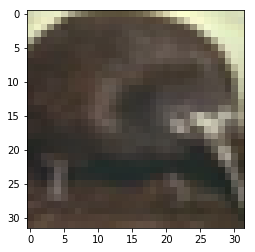

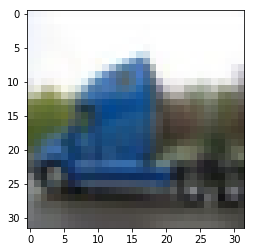

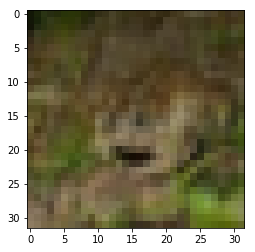

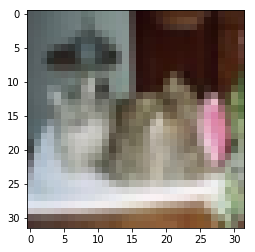

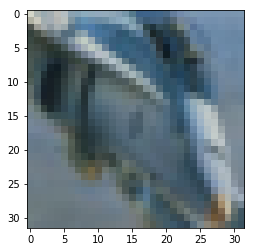

In [0]:
vz.plot_cifar10_files(train_ds2)

### Training - Build model , compile and train 

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D,  Activation, GlobalMaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization , Dense, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import AveragePooling2D,Flatten

import numpy as np
import math
n = 3
WEIGHT_DECAY=1.25e-4
depth = n * 9 + 2



def apply_weight(x):
  return x*0.125  

def random_pad_crop(image,padding=2):
  shp=tf.shape(image)
  
  image=tf.pad(image,[(0, 0), (padding, padding), (padding, padding), (0, 0)], mode='reflect')
  
  image=tf.image.random_crop(image,size=shp)
  return image  

def flip_left_right(image):
  return tf.image.random_flip_left_right(image)    

def aug1(image):
  print('is_training',is_training)
  if is_training:
    return ds.cutout(ds.random_pad_crop(image,padding=2),100,size=4)
    #return flip_left_right(random_pad_crop(image))
  else:
    print('inside validation cycle\n===============\n')
    return image  

def aug2(image):
  print('is_training',is_training)
  if is_training:
    return ds.cutout(ds.random_pad_crop(image,padding=1),100,size=2)
    #return flip_left_right(random_pad_crop(image))
  else:
    print('inside validation cycle\n===============\n')
    return image        

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
import random
def random_pad_crop(image,padding=4):
    padding = random.randint(1,5)
    shape=tf.shape(image)  
    image=tf.pad(image,[(padding, padding), (padding, padding), (0, 0)], mode='reflect')
    image=tf.image.random_crop(image,size=shape)
    return image  

def cutout_channel(batch, prob=50, size=8, min_size=5, use_fixed_size=True):
  #tf.print(img.shape)
  #print(batch.shape)
  #return tf.cond(tf.random.uniform([], 0, 100) > prob, true_fn = tf.map_fn(lambda channel: get_cutout_channel(channel,size,min_size,use_fixed_size),batch),false_fn = batch)
  return tf.map_fn(lambda channel: get_cutout_channel(channel,size,min_size,use_fixed_size,prob),batch)

def get_cutout_channel(img, size=8,min_size=2,use_fixed_size=True,prob = 50):
    img2 = img
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]
    channel = tf.shape(img)[2]
    area = tf.cast(width*height, tf.float32)
    if (use_fixed_size==True):
      s=size
    else:  
      s=tf.random.uniform([], min_size, size, tf.int32)
    x1 = tf.random.uniform([], 0, height+1-s , tf.int32) # get the x offset from top left
    y1 = tf.random.uniform([], 0, width+1-s , tf.int32)
    img1 = tf.ones_like(img)  
    #print(tf.shape(img1))
    cut_slice = tf.slice(
    img1,
    [x1, y1, 0],
    [s, s, channel])
    #create mask similar in shape to input image with cutout area having ones and rest of the area padded with zeros 
    mask = tf.image.pad_to_bounding_box(
      cut_slice,
      x1,
      y1,
      height,
      width
    )
    mask = tf.ones_like(mask) - mask
    tmp_img = tf.multiply(img,mask)
    cut_img =tmp_img
    #print(cut_img.shape)
    return tf.cond(tf.random.uniform([], 0, 100) > prob,lambda: cut_img,lambda: img2)
    


def random_crop_aug(batch,pad = 0):
  if is_training:
    #tf.print(batch.shape)
    return tf.map_fn(lambda channel: random_pad_crop(channel,padding=pad),batch)
  else:
    return batch


def rotate_aug(batch):
  if is_training:
    #print("in rotate")
    #tf.print(batch.shape)
    degree = random.randint(-11,11)
    return tf.map_fn(lambda channel: tfa.image.transform_ops.rotate(channel, math.radians(degree)), batch)
  else:
    #print('inside validation cycle\n===============\n')
    return batch


def flip_lr_aug(batch):
    #tf.print("Aug")
    if is_training:
      #tf.print(batch.shape)
      return tf.map_fn(lambda channel: flip_left_right(channel), batch)
    else:    
      return batch  

In [0]:
def resnet_v2(input_shape, depth, num_classes=10,distortion = 0):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)
    if distortion == 1:
      x = Lambda(random_crop_aug)(x)
    if distortion == 2:
      x = Lambda(rotate_aug)(x)
    if distortion == 3:
      x = Lambda(cutout_channel)(x)
    if distortion == 4:
      x = Lambda(flip_lr_aug)(x)
    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            if distortion == 5 and stage == 0:
              y = Lambda(random_crop_aug)(y)
            if distortion == 6 and stage == 0:
              y = Lambda(rotate_aug)(y)
            if distortion == 7 and stage == 0:
              y = Lambda(cutout_channel)(y)
            if distortion == 8 and stage == 0:
              y = Lambda(flip_lr_aug)(y)
            if distortion == 9 and stage == 1:
              y = Lambda(random_crop_aug)(y)
            if distortion == 10 and stage == 1:
              y = Lambda(rotate_aug)(y)
            if distortion == 11 and stage == 1:
              y = Lambda(cutout_channel)(y)
            if distortion == 12 and stage == 1:
              y = Lambda(flip_lr_aug)(y)
            if distortion == 13 and stage == 2:
              y = Lambda(random_crop_aug)(y)
            if distortion == 14 and stage == 2:
              y = Lambda(rotate_aug)(y)
            if distortion == 15 and stage == 2:
              y = Lambda(cutout_channel)(y)
            if distortion == 16 and stage == 2:
              y = Lambda(flip_lr_aug)(y)
              
            """
            if distortion == 2 and stage == 0:
              y = Lambda(aug2)(y)
            if distortion == 5 and stage == 1:
              y = Lambda(aug2)(y)
            if distortion == 8 and stage == 2:
              y = Lambda(aug2)(y)
            """
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            
            if distortion == 17 and stage == 0:
              y = Lambda(random_crop_aug)(y)
            if distortion == 18 and stage == 0:
              y = Lambda(rotate_aug)(y)
            if distortion == 19 and stage == 0:
              y = Lambda(cutout_channel)(y)
            if distortion == 20 and stage == 0:
              y = Lambda(flip_lr_aug)(y)
            if distortion == 21 and stage == 1:
              y = Lambda(random_crop_aug)(y)
            if distortion == 22 and stage == 1:
              y = Lambda(rotate_aug)(y)
            if distortion == 23 and stage == 1:
              y = Lambda(cutout_channel)(y)
            if distortion == 24 and stage == 1:
              y = Lambda(flip_lr_aug)(y)
            if distortion == 25 and stage == 2:
              y = Lambda(random_crop_aug)(y)
            if distortion == 26 and stage == 2:
              y = Lambda(rotate_aug)(y)
            if distortion == 27 and stage == 2:
              y = Lambda(cutout_channel)(y)
            if distortion == 28 and stage == 2:
              y = Lambda(flip_lr_aug)(y)
            """
            if distortion == 3 and stage == 0:
              y = Lambda(aug2)(y)
            if distortion == 6 and stage == 1:
              y = Lambda(aug2)(y)
            if distortion == 9 and stage == 2:
              y = Lambda(aug2)(y)
            """
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if distortion == 29 and stage == 0:
              y = Lambda(random_crop_aug)(y)
            if distortion == 30 and stage == 0:
              y = Lambda(rotate_aug)(y)
            if distortion == 31 and stage == 0:
              y = Lambda(cutout_channel)(y)
            if distortion == 32 and stage == 0:
              y = Lambda(flip_lr_aug)(y)
            if distortion == 33 and stage == 1:
              y = Lambda(random_crop_aug)(y)
            if distortion == 34 and stage == 1:
              y = Lambda(rotate_aug)(y)
            if distortion == 35 and stage == 1:
              y = Lambda(cutout_channel)(y)
            if distortion == 36 and stage == 1:
              y = Lambda(flip_lr_aug)(y)
            if distortion == 37 and stage == 2:
              y = Lambda(random_crop_aug)(y)
            if distortion == 38 and stage == 2:
              y = Lambda(rotate_aug)(y)
            if distortion == 39 and stage == 2:
              y = Lambda(cutout_channel)(y)
            if distortion == 40 and stage == 2:
              y = Lambda(flip_lr_aug)(y)
              
            """
            if distortion == 4 and stage == 0:
              y = Lambda(aug2)(y)
            if distortion == 7 and stage == 1:
              y = Lambda(aug2)(y)
            if distortion == 10 and stage == 2:
              y = Lambda(aug2)(y)
            """
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model




In [0]:
#model = resnet_v2(input_shape=(32,32,3), depth=depth)

In [0]:
#model.summary()

In [0]:

from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule():
    
    def schedule(epoch):

      lr=lr1=np.interp([epoch],[0, 5,24], [0.025, 0.4, 0])[0]
      print('epoch ', epoch+1, ': setting learning rate to ',lr1)
      return lr
    
    return LearningRateScheduler(schedule)

lr_sched = lr_schedule()


In [0]:

for model_params in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]:
  is_training=True
  print("Model Param:- ",model_params)
  model = resnet_v2(input_shape=(32,32,3), depth=depth, distortion = model_params)
  model.summary()
  #global_step = tf.train.get_or_create_global_step()
  #model=model=build_model(model_params)
  opt=SGD(lr=0.025,momentum=0.9,nesterov=True)
  model.compile(loss='categorical_crossentropy',
              optimizer=opt,metrics=['accuracy']
              )
  
  
  #if model_params in [0,4,5]:  
  train_ds=train_ds2  
  model.fit(train_ds,epochs=EPOCHS, steps_per_epoch=np.ceil(50000/batch_size), 
          callbacks=[lr_sched],
          verbose=1)
  is_training=False
  score=model.evaluate(test_ds, steps =np.ceil(10000/batch_size), verbose=1)

  del(model)
  del(train_ds)
  
  print('val accuracy score at the end of training model type ',model_params, score)
  print("=========================================\n")

#validation_data=test_ds, validation_steps=np.ceil(10000/batch_size),

Model Param:-  0
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 32, 32, 16)   64          conv2d_32[0][0]                  
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 32, 32, 16)   0           batch_normalization_29[0][0]     
___________________________________________________________________________

NameError: ignored

In [0]:
for model_params in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]:
  is_training=True
  print("Model Param:- ",model_params)
  model = resnet_v2(input_shape=(32,32,3), depth=depth, distortion = model_params)
  model.summary()
  #global_step = tf.train.get_or_create_global_step()
  #model=model=build_model(model_params)
  opt=SGD(lr=0.025,momentum=0.9,nesterov=True)
  model.compile(loss='categorical_crossentropy',
              optimizer=opt,metrics=['accuracy']
              )
  
  
  #if model_params in [0,4,5]:  
  train_ds=train_ds2  
  model.fit(train_ds,epochs=EPOCHS, steps_per_epoch=np.ceil(50000/batch_size), 
          callbacks=[lr_sched],
          verbose=1)
  is_training=False
  score=model.evaluate(test_ds, steps =np.ceil(10000/batch_size), verbose=1)

  del(model)
  del(train_ds)
  
  print('val accuracy score at the end of training model type ',model_params, score)
  print("=========================================\n")

#validation_data=test_ds, validation_steps=np.ceil(10000/batch_size),

Model Param:-  2
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
_____________________________________________________________________________

KeyboardInterrupt: ignored

In [0]:
for model_params in [12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]:
  is_training=True
  print("Model Param:- ",model_params)
  model = resnet_v2(input_shape=(32,32,3), depth=depth, distortion = model_params)
  model.summary()
  #global_step = tf.train.get_or_create_global_step()
  #model=model=build_model(model_params)
  opt=SGD(lr=0.025,momentum=0.9,nesterov=True)
  model.compile(loss='categorical_crossentropy',
              optimizer=opt,metrics=['accuracy']
              )
  
  
  #if model_params in [0,4,5]:  
  train_ds=train_ds2  
  model.fit(train_ds,epochs=EPOCHS, steps_per_epoch=np.ceil(50000/batch_size), 
          callbacks=[lr_sched],
          verbose=1)
  is_training=False
  score=model.evaluate(test_ds, steps =np.ceil(10000/batch_size), verbose=1)

  del(model)
  del(train_ds)
  
  print('val accuracy score at the end of training model type ',model_params, score)
  print("=========================================\n")

#validation_data=test_ds, validation_steps=np.ceil(10000/batch_size),

Model Param:-  12
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
____________________________________________________________________________

In [0]:
for model_params in [19,20,21,22,23,24,25]:
  is_training=True
  print("Model Param:- ",model_params)
  model = resnet_v2(input_shape=(32,32,3), depth=depth, distortion = model_params)
  model.summary()
  #global_step = tf.train.get_or_create_global_step()
  #model=model=build_model(model_params)
  opt=SGD(lr=0.025,momentum=0.9,nesterov=True)
  model.compile(loss='categorical_crossentropy',
              optimizer=opt,metrics=['accuracy']
              )
  
  
  #if model_params in [0,4,5]:  
  train_ds=train_ds2  
  model.fit(train_ds,epochs=EPOCHS, steps_per_epoch=np.ceil(50000/batch_size), 
          callbacks=[lr_sched],
          verbose=1)
  is_training=False
  score=model.evaluate(test_ds, steps =np.ceil(10000/batch_size), verbose=1)

  del(model)
  del(train_ds)
  
  print('val accuracy score at the end of training model type ',model_params, score)
  print("=========================================\n")

#validation_data=test_ds, validation_steps=np.ceil(10000/batch_size),

Model Param:-  19
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
____________________________________________________________________________

### Summary of Test Results 
Hyperparameters : Epochs:24, max_lr:0.4, momentum:0.9, L2-wt_decay on Conv Layers :1.25e-4 

| Trial | Augmentation strategy | Train accuracy |Test Accuracy | Hyperparameters |Comments |
| :--- | :---: | :---: | :---: | :---: | :--- |


**Validation accuracy went down when only Distortion was used in the mid/lower layers (after Res Blk1 and Res Blk2 ) But when used in combination with usual Image augmentation , there seems to be better Regularization and perhaps we could explore such an option. If we were to pursue only Distortion of middle or lower layers (with a good enough size of channels ) , we may need to try more stringent augmentation strategies to overcome the problem of overfitting**